In [ ]:
#link dataset
#https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [2]:
!pip install opencv-python seaborn

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
!pip install -q kaggle

from google.colab import files
files.upload()  # Upload file kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Tải dataset GTSRB
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip -q gtsrb-german-traffic-sign.zip -d /content/

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 85% 521M/612M [00:03<00:01, 72.5MB/s]
100% 612M/612M [00:03<00:00, 195MB/s] 


In [4]:
img_size = 64
train_dir = "/content/train"
test_csv_path = "/content/Test.csv"
test_img_dir = "/content/test"

In [5]:
def load_images_from_folder(folder_path, img_size):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder_path))

    for label in class_names:
        label_path = os.path.join(folder_path, label)
        if not os.path.isdir(label_path):
            continue
        for file in os.listdir(label_path):
            img_path = os.path.join(label_path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(int(label))
    return np.array(images), np.array(labels)

In [6]:
X, y = load_images_from_folder(train_dir, img_size)
print(f"Loaded {X.shape[0]} images. Shape: {X.shape}, Labels: {y.shape}")

Loaded 39209 images. Shape: (39209, 64, 64, 3), Labels: (39209,)


In [7]:
X = X.astype("float32") / 255.0
y_cat = to_categorical(y, num_classes=len(np.unique(y)))

X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

In [8]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_train)

In [9]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_cat.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,747 (2.63 MB)

 Trainable params: 688,747 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=20,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 57s 93ms/step - accuracy: 0.1795 - loss: 3.0428 - val_accuracy: 0.5645 - val_loss: 1.3826
Epoch 2/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step - accuracy: 0.4723 - loss: 1.6283 - val_accuracy: 0.7939 - val_loss: 0.6393
Epoch 3/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.6111 - loss: 1.1468 - val_accuracy: 0.8968 - val_loss: 0.3734
Epoch 4/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.6962 - loss: 0.8836 - val_accuracy: 0.9322 - val_loss: 0.2505
Epoch 5/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 0.7600 - loss: 0.7105 - val_accuracy: 0.9616 - val_loss: 0.1411
Epoch 6/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 80s 83ms/step - accuracy: 0.7984 - loss: 0.5941 - val_accuracy: 0.9665 - val_loss: 0.1086
Epoch 7/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.8404 - loss: 0.4829 - val_accuracy: 0.9827 - val_loss: 0.0755
Epoch 8/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - accuracy: 0.8689 - loss: 0.3949 - 

In [11]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_acc*100:.2f}%")

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9972 - loss: 0.0105
Validation accuracy: 99.74%


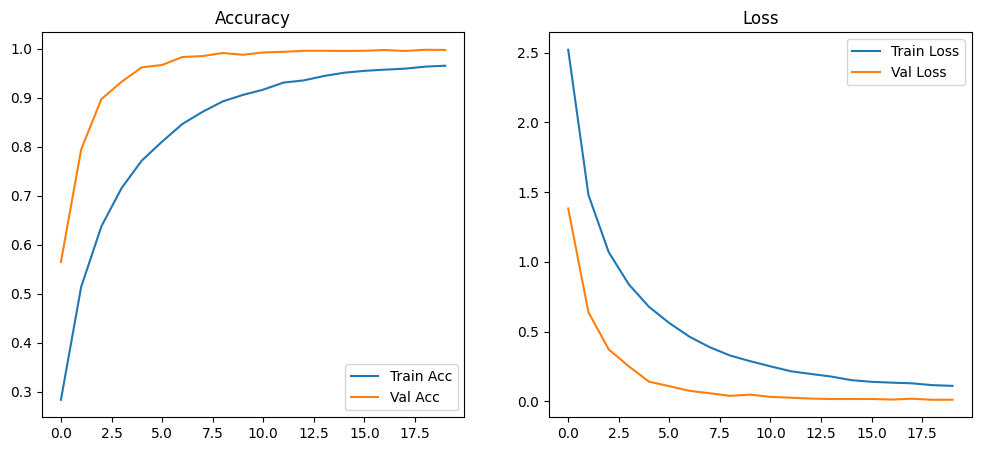

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.savefig("training_history.png")
plt.show()

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


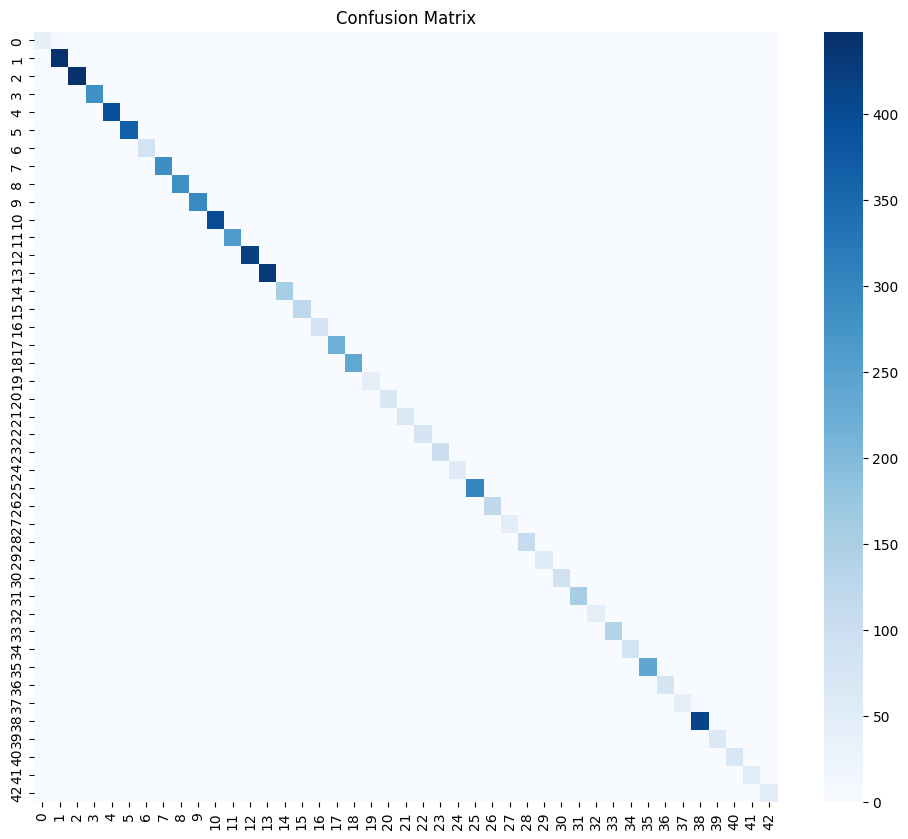

In [13]:
y_val_pred = model.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val, axis=1)

conf_mat = confusion_matrix(y_val_true_labels, y_val_pred_labels)

plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()


In [14]:
model.save("traffic_sign_cnn_model.keras")

In [15]:
files.download("traffic_sign_cnn_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>